In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.export.export_output import PredictOutput

tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
train_data[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [3]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1],name="input")

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    export_outputs={"SIGNATURE_NAME": PredictOutput({
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="final_result")
    })}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./logdir")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6dd724fd50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './logdir', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [5]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "final_result"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [6]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=50,
    num_epochs=2,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-8800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8801 into ./logdir/model.ckpt.
INFO:tensorflow:probabilities = [[0.0118202  0.00000319 0.00010712 0.00002891 0.00162196 0.20263898
  0.77043176 0.00000048 0.01333906 0.0000084 ]
 [0.00001455 0.00000008 0.00000861 0.00000206 0.00000301 0.00036274
  0.9992423  0.         0.00036679 0.00000003]
 [0.0001282  0.00000455 0.00067402 0.00011957 0.00017188 0.00153893
  0.99629575 0.00000091 0.00105129 0.00001479]
 [0.00000253 0.9976044  0.00012114 0.00049562 0.00030094 0.00029967
  0.00013728 0.00015353 0.00066162 0.00022328]
 [0.00014519 0.00002014 0.05313244 0.00042108 0.03128761 0.00035683
  0.91233754 0.00003004 0.00206639 0.00020281]
 [0.0099505  0.0049

INFO:tensorflow:global_step/sec: 119.342
INFO:tensorflow:probabilities = [[0.00172019 0.00000151 0.00000355 0.00061565 0.00017153 0.9949256
  0.00006438 0.00009543 0.00058971 0.00181249]
 [0.00211855 0.00000022 0.00000573 0.01761208 0.00000009 0.98000574
  0.00000118 0.00000308 0.00017394 0.00007945]
 [0.00000641 0.00000011 0.9966151  0.00337681 0.         0.00000082
  0.00000007 0.00000001 0.00000073 0.        ]
 [0.99916244 0.         0.00002997 0.00000291 0.00000021 0.00075962
  0.00003967 0.00000016 0.00000475 0.0000002 ]
 [0.00061066 0.00000002 0.00197368 0.00000078 0.00004439 0.00051391
  0.99683726 0.00000009 0.00001907 0.00000023]
 [0.00000303 0.00002219 0.00000997 0.00023293 0.01164516 0.00010259
  0.00000469 0.00167996 0.0004531  0.98584646]
 [0.9994785  0.00000021 0.00005633 0.00000873 0.00000056 0.00010336
  0.00016792 0.00001744 0.00014683 0.00002015]
 [0.00003594 0.00000021 0.9986389  0.00044594 0.         0.00000449
  0.00000001 0.         0.00087441 0.00000001]
 [0.0001

INFO:tensorflow:global_step/sec: 138.549
INFO:tensorflow:probabilities = [[0.00004865 0.00957899 0.00201192 0.983905   0.00002786 0.0027299
  0.00048427 0.00003338 0.00068541 0.00049461]
 [0.00090232 0.00000655 0.00442735 0.00388559 0.00103581 0.30444732
  0.00441206 0.00060762 0.671275   0.00900033]
 [0.00001832 0.00000011 0.00004441 0.00000029 0.00000505 0.00020252
  0.999718   0.         0.00001117 0.00000001]
 [0.00488286 0.00000154 0.00149345 0.0002506  0.00030583 0.14852569
  0.83324885 0.00000021 0.01121695 0.00007396]
 [0.0000278  0.00252504 0.00142318 0.00381035 0.9411376  0.00082496
  0.00139097 0.00035712 0.00100191 0.0475011 ]
 [0.06857105 0.00001476 0.01012561 0.889296   0.00000005 0.02447193
  0.00000188 0.00008555 0.00742819 0.00000488]
 [0.002198   0.02367377 0.00725572 0.03515486 0.01066409 0.04780907
  0.8228108  0.00006472 0.04981256 0.00055631]
 [0.00035643 0.01485915 0.0089813  0.00061001 0.00063156 0.00354296
  0.97029096 0.0000207  0.00068893 0.00001791]
 [0.9997

INFO:tensorflow:global_step/sec: 150.841
INFO:tensorflow:probabilities = [[0.00004808 0.9962205  0.00031207 0.00185448 0.0000486  0.00008544
  0.00014522 0.00049461 0.00057609 0.00021498]
 [0.00283407 0.00010216 0.0021991  0.00595596 0.01849904 0.07112435
  0.00797568 0.00479223 0.22468589 0.66183156]
 [0.00028413 0.00253929 0.00524001 0.03460054 0.00456445 0.89998585
  0.00568766 0.0002138  0.03806367 0.00882073]
 [0.8581614  0.00110378 0.01565721 0.00720386 0.00119109 0.02135531
  0.04035424 0.00056805 0.04510774 0.00929732]
 [0.01606978 0.00109038 0.00209618 0.77049017 0.00044603 0.20101552
  0.00328169 0.00068908 0.0037265  0.00109456]
 [0.00013561 0.00011348 0.00044266 0.00008495 0.00035865 0.00157991
  0.9748669  0.00000004 0.02239821 0.00001966]
 [0.03589836 0.0001648  0.00321421 0.06406685 0.04389853 0.6304105
  0.00277485 0.0009216  0.09337032 0.12528004]
 [0.9999325  0.         0.00000385 0.00000004 0.         0.0000587
  0.00000149 0.00000002 0.00000328 0.00000002]
 [0.00001

INFO:tensorflow:global_step/sec: 148.502
INFO:tensorflow:probabilities = [[0.00101977 0.92209417 0.01093954 0.00439574 0.00949782 0.0026704
  0.00437535 0.01706256 0.02605899 0.00188565]
 [0.00000401 0.00001156 0.00022118 0.00038948 0.02989377 0.00035261
  0.00001914 0.00867033 0.00105995 0.95937794]
 [0.00010616 0.98545814 0.00153268 0.00142589 0.00030992 0.00032793
  0.00063733 0.00093917 0.00806133 0.00120147]
 [0.00313954 0.00009058 0.9586137  0.0317133  0.00060426 0.00088818
  0.00100877 0.00036786 0.00320728 0.00036648]
 [0.00392178 0.00116441 0.00727868 0.00390466 0.20909849 0.00261087
  0.00218714 0.09087912 0.03459303 0.6443619 ]
 [0.00003044 0.00000034 0.9967759  0.00175912 0.00001435 0.00000103
  0.00115226 0.0000005  0.00026597 0.00000014]
 [0.00001645 0.00000154 0.9981346  0.00130185 0.00000001 0.00001869
  0.00000008 0.00000005 0.0005268  0.00000001]
 [0.00026923 0.00019457 0.00013477 0.00172145 0.01377881 0.00058107
  0.00004953 0.06154302 0.00099085 0.9207368 ]
 [0.0000

INFO:tensorflow:global_step/sec: 149.812
INFO:tensorflow:probabilities = [[0.00022303 0.96279573 0.00254426 0.00105039 0.00054389 0.00017879
  0.00087862 0.00036979 0.03052099 0.00089451]
 [0.00014737 0.00000264 0.00002233 0.00516617 0.00000324 0.9904439
  0.0002673  0.00000548 0.00382365 0.00011795]
 [0.00002061 0.00039702 0.00018852 0.0003025  0.00018338 0.00023661
  0.9980259  0.00000024 0.00063724 0.00000804]
 [0.00008768 0.9909259  0.0003088  0.00237064 0.0001493  0.00061093
  0.00191773 0.00103134 0.00188083 0.00071676]
 [0.00206566 0.00002952 0.00108715 0.58811945 0.00001173 0.35980707
  0.04516434 0.00010319 0.00360629 0.00000568]
 [0.9999429  0.         0.00000623 0.00000617 0.00000001 0.00002192
  0.00001938 0.00000027 0.0000029  0.00000015]
 [0.00011043 0.00000013 0.00000492 0.00001699 0.00002465 0.00001322
  0.00000013 0.97105163 0.00000814 0.02876986]
 [0.00013546 0.00000168 0.00037078 0.0002778  0.05193025 0.00015716
  0.00025589 0.00696225 0.00685606 0.9330528 ]
 [0.9999

INFO:tensorflow:global_step/sec: 150.808
INFO:tensorflow:probabilities = [[0.10494474 0.0013456  0.00568617 0.00157348 0.00027391 0.8466526
  0.01342469 0.00182828 0.02410838 0.0001621 ]
 [0.00000804 0.00000064 0.00000689 0.00037743 0.07388692 0.0001158
  0.00000804 0.00070213 0.00121066 0.92368346]
 [0.00935295 0.00000685 0.00082225 0.01228161 0.00155416 0.07833473
  0.00296064 0.0000003  0.8941364  0.00055007]
 [0.00007825 0.9956065  0.00070322 0.00075685 0.00006239 0.00024985
  0.00084827 0.00009793 0.00144927 0.00014753]
 [0.00009784 0.00000047 0.00002406 0.00006753 0.00307008 0.0003782
  0.00000202 0.10626253 0.00005215 0.89004517]
 [0.00002947 0.00000467 0.00381792 0.00250454 0.00000579 0.0064135
  0.0000121  0.00025035 0.98679394 0.00016772]
 [0.00003591 0.9638546  0.00064242 0.00948189 0.00012937 0.00020573
  0.00009091 0.02041891 0.00453059 0.00060958]
 [0.00573666 0.00201974 0.00092588 0.498534   0.00175277 0.23166853
  0.00011699 0.00007317 0.25626588 0.00290645]
 [0.0010083

INFO:tensorflow:global_step/sec: 149.881
INFO:tensorflow:probabilities = [[0.00005137 0.00000604 0.974007   0.00026079 0.0072744  0.00002151
  0.0000051  0.00001811 0.00095874 0.017397  ]
 [0.00014546 0.9776038  0.00096395 0.00159469 0.00015492 0.00010704
  0.00022208 0.0002248  0.01808504 0.00089825]
 [0.00102005 0.00001231 0.00011674 0.00001009 0.9700366  0.00465083
  0.01012519 0.00205225 0.00250935 0.00946658]
 [0.00000501 0.00041054 0.00011896 0.00075054 0.00000941 0.00008858
  0.00000019 0.99416566 0.00018945 0.00426154]
 [0.00005276 0.00004337 0.00049586 0.00003801 0.00018463 0.0004877
  0.9982509  0.00000011 0.00044265 0.00000399]
 [0.00010766 0.00001328 0.00015255 0.9933703  0.00000015 0.00630559
  0.00003121 0.00000131 0.0000149  0.00000314]
 [0.00000033 0.00012258 0.00067201 0.9896298  0.00001572 0.00018683
  0.00000283 0.00006178 0.00850494 0.00080311]
 [0.00003489 0.9252842  0.00107676 0.02736496 0.000182   0.00733245
  0.00006758 0.01590809 0.01430141 0.00844772]
 [0.0006

INFO:tensorflow:global_step/sec: 150.417
INFO:tensorflow:probabilities = [[0.00004088 0.07655882 0.00006529 0.02766456 0.03194444 0.12168548
  0.0001632  0.13708133 0.00855214 0.59624386]
 [0.00000961 0.00000084 0.00053961 0.00000029 0.00011769 0.00005199
  0.9992483  0.00000001 0.00003138 0.00000031]
 [0.00260189 0.00008139 0.00089089 0.00011874 0.00025373 0.06609049
  0.9155765  0.00000025 0.01438212 0.00000395]
 [0.00001015 0.00000055 0.00069189 0.00000039 0.0004873  0.0000425
  0.998451   0.00000001 0.00031571 0.00000059]
 [0.0000087  0.00003164 0.00000112 0.00100946 0.02301721 0.00063314
  0.00000312 0.02504862 0.00230319 0.9479437 ]
 [0.00002246 0.00034184 0.00002917 0.0007851  0.20839109 0.00450035
  0.00010338 0.23990813 0.02297484 0.52294374]
 [0.00000472 0.97821873 0.00051851 0.00701668 0.00022728 0.00002326
  0.00003527 0.00784198 0.00380322 0.00231049]
 [0.00403774 0.00004068 0.01280771 0.16837163 0.00000342 0.05055236
  0.00058701 0.00157056 0.76182663 0.00020227]
 [0.0026

INFO:tensorflow:global_step/sec: 149.055
INFO:tensorflow:probabilities = [[0.0185073  0.00007993 0.00955742 0.95451814 0.00000113 0.01005478
  0.00016813 0.00004183 0.00697067 0.00010063]
 [0.00019277 0.00002472 0.00030622 0.00050389 0.07882611 0.00998014
  0.00032503 0.00268884 0.00369487 0.90345734]
 [0.00026011 0.00000282 0.00001645 0.00001861 0.98037213 0.00407724
  0.00099294 0.00161883 0.00090082 0.01173996]
 [0.00000322 0.0003018  0.00037851 0.00015105 0.54051095 0.00354138
  0.00036941 0.00193075 0.4240903  0.02872271]
 [0.00004333 0.00000064 0.00114833 0.00000029 0.00008307 0.00001541
  0.9986884  0.00000001 0.00001977 0.00000088]
 [0.00006342 0.001404   0.00082022 0.9685149  0.00004691 0.01541709
  0.00007894 0.00020262 0.01080898 0.00264289]
 [0.00000611 0.00000063 0.00000217 0.00194314 0.00478337 0.00021023
  0.00000016 0.2937926  0.00018911 0.69907254]
 [0.0013009  0.00000184 0.00012486 0.42092854 0.00002201 0.44508907
  0.00000262 0.00159182 0.10332226 0.02761608]
 [0.001

INFO:tensorflow:global_step/sec: 151.333
INFO:tensorflow:probabilities = [[0.9989484  0.00000002 0.000019   0.00000016 0.00000069 0.00061272
  0.00007068 0.00000015 0.00034759 0.0000006 ]
 [0.00102013 0.00640476 0.00343126 0.00500828 0.0002544  0.02139215
  0.00261459 0.00003192 0.95784134 0.00200114]
 [0.0010762  0.00000963 0.00004674 0.00111736 0.0012905  0.9566434
  0.00571084 0.00001098 0.02056061 0.01353387]
 [0.00002807 0.00000025 0.00033416 0.0000019  0.00004663 0.00041277
  0.999111   0.         0.00006299 0.00000223]
 [0.00002866 0.99591583 0.00061754 0.00047317 0.00067598 0.00001439
  0.00027124 0.00093946 0.00095617 0.00010758]
 [0.00170972 0.82993007 0.11331136 0.01699566 0.00868016 0.00082953
  0.00027684 0.01271599 0.01274349 0.00280715]
 [0.81981164 0.00002834 0.00409454 0.00586811 0.00010806 0.02832964
  0.00456594 0.00192505 0.12342568 0.01184297]
 [0.00008069 0.98910916 0.0030701  0.00136928 0.00059925 0.00004143
  0.00153504 0.0029675  0.00099308 0.00023456]
 [0.0000

INFO:tensorflow:global_step/sec: 153.52
INFO:tensorflow:probabilities = [[0.00000243 0.99877375 0.0002536  0.00024221 0.00000794 0.00001123
  0.00003167 0.00025608 0.00039211 0.00002905]
 [0.00050138 0.00075537 0.00237154 0.01601441 0.0052812  0.00213723
  0.00008379 0.14139028 0.00900267 0.82246214]
 [0.00000044 0.00000131 0.00000818 0.00000463 0.99872345 0.00000722
  0.00005863 0.00010851 0.00030544 0.0007821 ]
 [0.00013422 0.00130929 0.8800894  0.11406477 0.00006935 0.00013269
  0.00022589 0.00089738 0.00296629 0.00011073]
 [0.00177023 0.00000025 0.00000994 0.00225785 0.00003557 0.9947547
  0.00000651 0.00016396 0.00060283 0.00039816]
 [0.00000021 0.00000002 0.00000005 0.00000157 0.00000016 0.00000228
  0.         0.9998517  0.00000016 0.0001438 ]
 [0.00000856 0.98862654 0.0004278  0.00122317 0.00019152 0.0000183
  0.00006783 0.00729139 0.00141777 0.00072699]
 [0.00202616 0.00000176 0.00013159 0.00010295 0.00001141 0.97646517
  0.00005428 0.00004471 0.02029526 0.00086685]
 [0.698611

INFO:tensorflow:global_step/sec: 150.36
INFO:tensorflow:probabilities = [[0.04370407 0.00036872 0.00913204 0.00058415 0.00022212 0.00532147
  0.00095821 0.00039817 0.9224912  0.01681981]
 [0.01989184 0.00015396 0.01074238 0.00016952 0.00411107 0.9108262
  0.04722334 0.00003101 0.00508986 0.00176078]
 [0.5072173  0.00001155 0.46667886 0.0032333  0.00006194 0.00314631
  0.00050865 0.01804825 0.00006244 0.00103138]
 [0.00017461 0.00018326 0.00028468 0.97244376 0.00001525 0.01003218
  0.0000461  0.00983919 0.00091082 0.00607019]
 [0.00026945 0.00000064 0.00096087 0.97304475 0.00000023 0.02236298
  0.00000007 0.00000274 0.00313446 0.00022389]
 [0.00418626 0.00443112 0.0052128  0.00180834 0.00755863 0.04516249
  0.00556793 0.00150991 0.9139851  0.01057744]
 [0.00227467 0.00063269 0.00272428 0.0081974  0.1623346  0.00033954
  0.00101287 0.01963965 0.01227578 0.7905686 ]
 [0.00000002 0.00000028 0.00000089 0.00008578 0.9940416  0.00000027
  0.00000033 0.00000442 0.00003275 0.00583366]
 [0.00000

INFO:tensorflow:global_step/sec: 151.031
INFO:tensorflow:probabilities = [[0.00068306 0.00000728 0.00001745 0.10250138 0.00002298 0.02225895
  0.00000074 0.5594427  0.00057712 0.31448838]
 [0.0000005  0.00000002 0.00006523 0.00001798 0.00000092 0.00000083
  0.00000017 0.9996916  0.00001781 0.00020487]
 [0.00603937 0.00004004 0.00686434 0.00037555 0.00619672 0.0015146
  0.9762922  0.00023182 0.00189036 0.00055501]
 [0.00088581 0.00012704 0.00785957 0.96482086 0.00001965 0.00130511
  0.00001129 0.00022161 0.01505579 0.00969328]
 [0.00079851 0.00003421 0.00042046 0.00133436 0.00020669 0.01539485
  0.00220773 0.00001973 0.979031   0.00055252]
 [0.99267197 0.00000053 0.00113416 0.00012176 0.0000013  0.00571561
  0.00007673 0.00000528 0.00022026 0.00005244]
 [0.00006014 0.00000112 0.99107856 0.00329228 0.00001581 0.00001664
  0.00503357 0.00000664 0.00048801 0.00000708]
 [0.00046282 0.00000198 0.00003417 0.00438282 0.02228218 0.00307453
  0.00005033 0.01984058 0.00294023 0.94693035]
 [0.0000

INFO:tensorflow:global_step/sec: 149.997
INFO:tensorflow:probabilities = [[0.00138114 0.02865224 0.00120685 0.01014319 0.0001825  0.05346859
  0.00048063 0.00556558 0.89629894 0.00262034]
 [0.01817049 0.00206824 0.11904165 0.1737672  0.11524613 0.07565878
  0.30854353 0.03197226 0.10770502 0.04782673]
 [0.99996257 0.00000004 0.00000475 0.00000201 0.00000062 0.00000749
  0.00000771 0.00000162 0.00001134 0.00000189]
 [0.00000584 0.00002381 0.00009228 0.0001658  0.03989245 0.00010461
  0.00003693 0.00037942 0.00163283 0.957666  ]
 [0.00026898 0.00006703 0.00023175 0.9908414  0.00000396 0.00822026
  0.0000832  0.00000203 0.0001063  0.00017511]
 [0.00000011 0.         0.00000001 0.00000131 0.00000002 0.00000005
  0.         0.9998196  0.00000003 0.00017884]
 [0.00043971 0.00584887 0.00152812 0.9624419  0.0002516  0.02712953
  0.00042083 0.00063807 0.00061407 0.00068738]
 [0.00001711 0.9954432  0.000357   0.00088711 0.0000836  0.0003782
  0.00010914 0.00054076 0.00191076 0.00027312]
 [0.0000

INFO:tensorflow:global_step/sec: 149.203
INFO:tensorflow:probabilities = [[0.00022452 0.00000084 0.00277542 0.99635893 0.         0.00058057
  0.         0.00004346 0.00000241 0.00001385]
 [0.99756867 0.00000001 0.00000448 0.00003874 0.00000021 0.00199988
  0.00008884 0.00014315 0.00014744 0.00000863]
 [0.00088061 0.00087915 0.00064605 0.00037131 0.00048667 0.9139536
  0.08102328 0.00009388 0.00164458 0.00002085]
 [0.00109157 0.         0.9955519  0.00073939 0.0000002  0.00000482
  0.00000989 0.00000157 0.00259311 0.0000075 ]
 [0.00000823 0.00001201 0.00000804 0.8818389  0.00004036 0.11438706
  0.00001058 0.00084355 0.00124024 0.00161102]
 [0.00203462 0.00051137 0.00021079 0.00401846 0.00159034 0.00245936
  0.9858781  0.00002129 0.00288589 0.00038981]
 [0.0007504  0.00056396 0.00376437 0.00020535 0.03333718 0.00085434
  0.9578031  0.00005979 0.00223729 0.00042422]
 [0.00061524 0.95880896 0.00565296 0.00337564 0.00266049 0.00160239
  0.00228441 0.01141045 0.01317618 0.00041324]
 [0.0000

INFO:tensorflow:global_step/sec: 150.223
INFO:tensorflow:probabilities = [[0.00009507 0.00003557 0.00107026 0.02066402 0.94804025 0.00028285
  0.00043564 0.00221275 0.00021082 0.02695268]
 [0.00013251 0.00042941 0.00408586 0.9587132  0.0000013  0.0108315
  0.00000075 0.00006661 0.02539222 0.00034655]
 [0.00007688 0.88700926 0.02304958 0.00466055 0.00125602 0.00005581
  0.00024551 0.07944255 0.00363274 0.00057106]
 [0.00214531 0.00000047 0.00108586 0.00002032 0.88629746 0.00254488
  0.08885618 0.00157698 0.01722534 0.00024709]
 [0.00101654 0.00004106 0.05440154 0.00140087 0.02405949 0.00048913
  0.00034562 0.03022396 0.11020932 0.7778125 ]
 [0.00010186 0.0036865  0.00431055 0.0049992  0.9495512  0.00163304
  0.01332715 0.00069103 0.00209936 0.0196001 ]
 [0.00232538 0.00293519 0.00085992 0.00753827 0.00036985 0.89993256
  0.0044371  0.0006601  0.07875472 0.00218701]
 [0.00003446 0.00000032 0.00007598 0.00010737 0.00004395 0.00008312
  0.00000023 0.99142987 0.00001026 0.00821438]
 [0.0000

INFO:tensorflow:global_step/sec: 153.389
INFO:tensorflow:probabilities = [[0.00000084 0.0000232  0.00008569 0.99972147 0.00000014 0.00004937
  0.00000001 0.00002216 0.00003164 0.00006545]
 [0.9194216  0.00000374 0.03672368 0.00040942 0.0001595  0.00236489
  0.00166477 0.00015548 0.03858433 0.00051245]
 [0.00061865 0.00000395 0.00000114 0.00222095 0.00062529 0.07768055
  0.00004106 0.8399539  0.0000712  0.07878335]
 [0.00138074 0.00000089 0.00535659 0.00023039 0.00001895 0.00008056
  0.00049346 0.0000078  0.99229217 0.00013844]
 [0.0000027  0.         0.00000101 0.01217033 0.00000034 0.9868907
  0.00000001 0.00000035 0.00092703 0.00000757]
 [0.00007661 0.00000125 0.00003937 0.00649008 0.00000425 0.9908105
  0.00000033 0.00002434 0.00091    0.00164326]
 [0.00001922 0.98867804 0.00012503 0.00020795 0.00036687 0.00046002
  0.00170699 0.00023143 0.00774807 0.00045637]
 [0.00016405 0.00307617 0.00163385 0.95146227 0.00051842 0.00183331
  0.0002092  0.00006969 0.02956658 0.01146636]
 [0.01123

INFO:tensorflow:global_step/sec: 149.917
INFO:tensorflow:probabilities = [[0.00036106 0.00000152 0.02663797 0.00176974 0.00000518 0.01023452
  0.03168938 0.00000005 0.92924464 0.00005598]
 [0.00005083 0.0000006  0.0012899  0.00054436 0.00000063 0.00003716
  0.00000002 0.99719256 0.00002544 0.00085848]
 [0.0001175  0.00000949 0.00278362 0.96459186 0.00005754 0.01512681
  0.00003722 0.00000102 0.01651982 0.00075513]
 [0.00080158 0.00006981 0.00012065 0.0000208  0.00085179 0.00522832
  0.98820645 0.00000007 0.00469203 0.00000842]
 [0.00003053 0.00000004 0.00000024 0.00005372 0.00000011 0.99934703
  0.00000177 0.00000006 0.00056263 0.0000039 ]
 [0.00048347 0.00021417 0.0007492  0.000372   0.00007664 0.00004081
  0.00019048 0.00000254 0.99767154 0.00019912]
 [0.00003034 0.9937477  0.00054778 0.00146935 0.00034055 0.00016218
  0.00026029 0.00208202 0.0011048  0.00025509]
 [0.2807207  0.00699584 0.007122   0.0964144  0.00172808 0.2015134
  0.01781777 0.15808217 0.02722925 0.20237635]
 [0.0001

INFO:tensorflow:global_step/sec: 149.18
INFO:tensorflow:probabilities = [[0.00031788 0.00830303 0.9530382  0.03453609 0.00000043 0.0000366
  0.0000542  0.00004119 0.00366988 0.00000249]
 [0.00003559 0.99702746 0.00055531 0.00004434 0.00001398 0.00001981
  0.00006702 0.00007515 0.00214057 0.00002089]
 [0.00007926 0.00001631 0.00249332 0.00006368 0.00789791 0.0000562
  0.98926836 0.00000056 0.00009    0.00003428]
 [0.00000101 0.00000029 0.00030955 0.00001063 0.9959331  0.0000011
  0.00062102 0.00042288 0.00045877 0.00224158]
 [0.0000007  0.00000031 0.00055665 0.00000406 0.99867046 0.00000479
  0.00002913 0.00013724 0.00008937 0.00050738]
 [0.00122755 0.00038262 0.00056181 0.00664205 0.00100142 0.01252735
  0.9754294  0.00000203 0.00214391 0.00008189]
 [0.00000072 0.00000262 0.00216192 0.9969879  0.         0.0003672
  0.00000042 0.00000002 0.00047923 0.00000012]
 [0.00153562 0.0020205  0.94147575 0.00791033 0.00027386 0.00094632
  0.00111869 0.02224396 0.02076889 0.00170605]
 [0.00055377

INFO:tensorflow:global_step/sec: 150.854
INFO:tensorflow:probabilities = [[0.00000636 0.00004837 0.00001906 0.0084995  0.00948605 0.00099537
  0.00000248 0.01345702 0.00017427 0.96731156]
 [0.00031459 0.0000166  0.0030238  0.03466952 0.00035793 0.00965623
  0.00125805 0.00000673 0.94351524 0.00718137]
 [0.00001551 0.00005361 0.00027168 0.01283478 0.03957579 0.00947332
  0.00013257 0.14135237 0.00689365 0.7893967 ]
 [0.00020542 0.98229367 0.00444759 0.00189938 0.00181196 0.00032973
  0.00189296 0.0020533  0.004105   0.00096102]
 [0.00000108 0.00002311 0.00000723 0.00040232 0.00003956 0.00043651
  0.00000008 0.97676986 0.00076434 0.02155584]
 [0.00001821 0.00028026 0.00957266 0.9791191  0.00000201 0.00892629
  0.00003007 0.00114945 0.00071352 0.00018841]
 [0.0000002  0.9996966  0.00001744 0.00003274 0.00001799 0.00000192
  0.00002358 0.00001604 0.00016255 0.00003101]
 [0.00001057 0.00000039 0.00002616 0.00001988 0.01696974 0.00030959
  0.00000021 0.00180056 0.00016271 0.98070014]
 [0.007

INFO:tensorflow:global_step/sec: 149.69
INFO:tensorflow:probabilities = [[0.00010754 0.00000555 0.9815653  0.00011461 0.01202833 0.00009023
  0.00558496 0.00000331 0.00046774 0.00003243]
 [0.00000933 0.00000001 0.0000036  0.00000027 0.00004268 0.00000263
  0.99992096 0.         0.00001834 0.00000213]
 [0.00458936 0.00695176 0.09947069 0.63784945 0.00632385 0.04598432
  0.00099624 0.0001831  0.18287231 0.01477895]
 [0.00001282 0.00014436 0.99260396 0.0070576  0.00001108 0.00005428
  0.0000008  0.00004103 0.00004788 0.00002613]
 [0.00019828 0.00004411 0.00014258 0.00070074 0.00002276 0.9815165
  0.00797351 0.00000054 0.00916036 0.00024055]
 [0.00000017 0.00000001 0.00000012 0.00000109 0.00000022 0.00000014
  0.         0.99978465 0.00000236 0.00021118]
 [0.00000632 0.00000007 0.00001024 0.9999125  0.         0.0000678
  0.0000001  0.00000001 0.0000023  0.00000053]
 [0.00003374 0.00682716 0.9916707  0.00104183 0.00000048 0.00000242
  0.00040639 0.00000007 0.00001691 0.0000002 ]
 [0.000000

INFO:tensorflow:Saving checkpoints for 11000 into ./logdir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.16941984.


In [7]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-19-16:24:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-19-16:24:33
INFO:tensorflow:Saving dict for global step 11000: accuracy = 0.9564, global_step = 11000, loss = 0.15666012
{'loss': 0.15666012, 'global_step': 11000, 'accuracy': 0.9564}


In [8]:
# Export the model to saved_model.pb file
def serving_input_receiver():
    inputs = {"x": tf.placeholder(dtype=tf.float32, shape=[1,28,28,1])}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = mnist_classifier.export_savedmodel(
    export_dir_base = "./logdir",
    serving_input_receiver_fn = serving_input_receiver,
    as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default', 'SIGNATURE_NAME']
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-11000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./logdir/temp-1526747073/saved_model.pb


INFO:tensorflow:Restoring parameters from ./logdir/1526747073/variables/variables
('Number: ', 0)


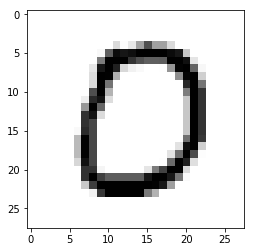

In [9]:
# Evaluate a sample image and display it
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor

%matplotlib inline

image = eval_data[10].reshape(-1,28,28,1)

predict_fn = predictor.from_saved_model(export_dir)
predictions = predict_fn(
    {"x": image})

print("Number: ", predictions['classes'][0])

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);

In [12]:
import tensorflow as tf
import numpy as np
import time
import argparse

def load_graph(model_file):
	graph = tf.Graph()
	graph_def = tf.GraphDef()

	with open(model_file, "rb") as f:
		graph_def.ParseFromString(f.read())
	with graph.as_default():
		tf.import_graph_def(graph_def)

	return graph

def predict(graph, image):
	input_operation = graph.get_operation_by_name("import/Placeholder");
	output_operation = graph.get_operation_by_name("import/final_result");
	
    
	with tf.Session(graph=graph) as sess:
		start = time.time()
		results = sess.run(output_operation.outputs[0],
		  	{input_operation.outputs[0]: image})
		end=time.time()
	results = np.squeeze(results)
	return results, end-start

mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

graph = load_graph(export_dir + "/eightbit.pb")

accuracies = []
times = []

for i in range(0, len(eval_labels)):

    image = eval_data[i].reshape(1,28,28,1)
    results, prediction_time = predict(graph, image)
    predicted = results.argsort()[::-1][0]
    accuracies.append(float(predicted==eval_labels[i]))
    times.append(prediction_time)
    
print(np.mean(accuracies))
print(np.mean(times))
    

0.956
0.034316586303710934


In [ ]:
eval_labels[1]

In [ ]:
eightbit: 0.9473
optimized: 0.9479
    frozen:0.9479
        
        
        
        
        0.9564
0.04397344245910645